In [1]:
import pandas as pd
import re
from tqdm import tqdm_notebook

prefix = 'data/'

In [2]:
df_all = pd.read_csv(prefix +"/second_batch_training_data.csv",index_col=0)

In [3]:
df_all.shape

(53161, 4)

In [4]:
df_all = df_all.drop_duplicates()
df_all.isna().sum()
# if both text_in_img and text_in_html are empty
df_all.dropna(subset=['text_in_img', 'text_in_html'], how='all', inplace = True)


In [5]:
df_all.shape

(51188, 4)

In [6]:
df_all = df_all.fillna("")

In [7]:
df_all.head()

,subject,text_in_html,text_in_img,label
0,"Your AUMA News Clippings for June 4, 2019",Your AUMA News Clippings Energy Energy has big...,AUMA ASC WE ARE WE ARE THE WE ARE THE economie...,0
1,FIT Networking,Save the Date! F.I.T. Summer Camp Graduation C...,SOLITA'S HOUSE Providing the Keys to Homeowner...,0
2,Upcoming Events& Info You Don't Want to Miss!,You don't want to miss these events! What's Gr...,TangerOutlets FARMERS MARKET BLUFFTON SOUTH C...,0
3,"Aberdeen Lake Dam Repairs, NC 211 expansion, a...",You don't want to miss these events Edition 21...,Town of Aberdeen,0
4,Call GEN3 for your Air Conditioning Needs!,You don't want to miss this great first-servic...,OK GENERA NOILY HEAT TING & AIR Generation 3 E...,0


In [8]:
df_all.groupby('label').count()

,subject,text_in_html,text_in_img
label,,,
0,50308,50308,50308
1,880,880,880


In [9]:
df_spam= df_all[df_all['label']==1]
df_spam.shape

(880, 4)

In [10]:
TEXT_HTML_THRESHOLD =120

In [11]:
import re
import unicodedata
def remove_emoji(s):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', s)

In [12]:
def clean_text(s):
    s = unicodedata.normalize("NFKD", s)
    # half space
    s=s.replace('\u200c', '')
    # BOM char
    s=s.replace('\ufeff', '')
    
    # remove unwantted chars
    s=re.sub('_+', ' ',s)
    s=re.sub('\*+', ' ',s)
    s=re.sub('-+', ' ',s)
    s=re.sub('=+', ' ',s)
    s=re.sub('>+', ' ',s)
    s=re.sub('<+', ' ',s)
    # strip multiple spaces
    s= re.sub('\s+', ' ', s).strip()
    s = remove_emoji(s)
    # ignore single char
    s= ' '.join([c for c in s.split()  if len(c) >1 or c == 'I'])
    return s

In [14]:
def build_whole_text(r,c1,c2,c3):
    s=r[c1].strip()+' '+r[c2].strip()
    if len(r[c2]) < TEXT_HTML_THRESHOLD:
        s=s+' '+r[c3].strip()
    return clean_text(s)

df_all['text'] = df_all.apply (lambda row: build_whole_text(row,'subject', 'text_in_html', 'text_in_img'), axis=1)


In [15]:
df_all['text_len']=df_all['text'].str.len()

In [16]:
df_all[df_all['text_len'] >=TEXT_HTML_THRESHOLD].count()

subject         50553
text_in_html    50553
text_in_img     50553
label           50553
text            50553
text_len        50553
dtype: int64

In [17]:
df_all['text_len'].quantile(0.04)

204.0

In [18]:
df_all['text_len'].min()

0

In [19]:
df_all['text_len'].max()

410179

In [20]:
df_all['text_len'].mean()

2115.4497538485584

In [21]:
df_all[df_all['text_len'] < 10000].hist(column='text_len', bins=50)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29c5e06ac8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29c5a05198>]],
      dtype=object)

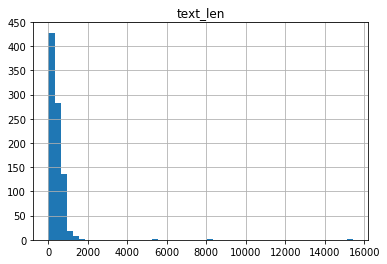

In [22]:
df_all[df_all['label'] == 1].hist(column='text_len', bins=50)

In [23]:
df_spam= df_all[df_all['label'] == 1]
df_spam.count()

subject         880
text_in_html    880
text_in_img     880
label           880
text            880
text_len        880
dtype: int64

In [24]:
df_spam[df_spam['text_len']<120].count()

subject         285
text_in_html    285
text_in_img     285
label           285
text            285
text_len        285
dtype: int64

In [25]:
df_all[df_all['text_len']<TEXT_HTML_THRESHOLD].groupby('label').count()

,subject,text_in_html,text_in_img,text,text_len
label,,,,,
0,350,350,350,350,350
1,285,285,285,285,285


In [26]:
# drop if text length is too short
df_new=df_all[df_all['text_len'] >= 120]

In [27]:
df_new.shape

(50553, 6)

In [28]:
df_new.groupby('label').count()

,subject,text_in_html,text_in_img,text,text_len
label,,,,,
0,49958,49958,49958,49958,49958
1,595,595,595,595,595


In [29]:
df_bert = pd.DataFrame({
    'id':range(len(df_new)),
    'label':df_new['label'],
    'alpha':['a']*df_new.shape[0],
    'text': df_new['text'] 
})

In [30]:
df_bert.isna().sum()

id       0
label    0
alpha    0
text     0
dtype: int64

In [31]:
df_bert.shape

(50553, 4)

In [32]:
df_bert['text']

0        Your AUMA News Clippings for June 4, 2019 Your...
1        FIT Networking Save the Date! F.I.T. Summer Ca...
2        Upcoming Events& Info You Don't Want to Miss! ...
3        Aberdeen Lake Dam Repairs, NC 211 expansion, a...
4        Call GEN3 for your Air Conditioning Needs! You...
5        There's Still Time to Save on Your AC Tune Up!...
6        Faithful Departed In Memoriam Marian C. Edward...
7        Elder Forum Baptism at the Beach Work Day Elde...
8        Boletín de Formación Seminario de Slotting S...
9        Farmer's Market Friday is here... ...at H2O! I...
10       Media Advisory: Two SCS Board Members Receive ...
11       Free Estate Planning Presentation! Gallagher J...
12       Memorial Day 2019 Office Closed for the Holida...
13       July 2019 Newsletter: Summer Season Fun Should...
14       LAST CHANCE! TEEN NIGHT IS TOMORROW! Register ...
15       Weekend Festivities!! You don't want to miss t...
16       Reminder: What You Should Know About Cranial C.

In [33]:
X = df_bert[['id','alpha','text']]
y = df_bert['label']

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

train_df = pd.DataFrame({
    'id': X_train['id'],
    'label':y_train,
    'alpha': ['a']*X_train.shape[0],
    'text': X_train['text']
})


test_df = pd.DataFrame({
    'id': X_test['id'],
    'label':y_test,
    'alpha': ['a']*X_test.shape[0],
    'text': X_test['text']
})

In [35]:
test_df.shape

(10111, 4)

In [36]:
train_df.shape

(40442, 4)

In [37]:
train_df.to_csv(prefix+'train.tsv', sep='\t', index=False, header=False)
test_df.to_csv(prefix+'dev.tsv', sep='\t', index=False, header=False)

In [38]:
!aws  s3 cp data/dev.tsv s3://sagemaker-us-east-1-665028136136/compliance-data/batch2/
!aws  s3 cp data/train.tsv s3://sagemaker-us-east-1-665028136136/compliance-data/batch2/

upload: data/dev.tsv to s3://sagemaker-us-east-1-665028136136/compliance-data/batch2/dev.tsv
upload: data/train.tsv to s3://sagemaker-us-east-1-665028136136/compliance-data/batch2/train.tsv


In [ ]:
!ls